# Downstream Analysis

After performing all of the preprocessing with `spatialproteomics`, you typically want to use other packages to extract further information from the data. Here, we show two examples, one using `squidpy` and the other one using the R package `spatstat`. `Spatialproteomics` provides several ways to export your data to facilitate interoperability with external tools.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

import xarray as xr
import spatialproteomics as sp
import pandas as pd
import squidpy as sq

celltype_colors = {
    "B cell": "#5799d1",
    "T cell": "#ebc850",
    "Myeloid cell": "#de6866",
    "Dendritic cell": "#4cbcbd",
    "Macrophage": "#bb7cb4",
    "Stromal cell": "#62b346",
    "Endothelial cell": "#bf997d",
}

/home/meyerben/meyerben/.conda/envs/tmp_env_3/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
# loading in a data set
ds = xr.open_zarr("../../data/LN_11_1.zarr")
# for clearer visualizations, we set the cell types to the broadest level (B cells, T cells, ...)
ds = ds.la.set_label_level("labels_0", ignore_neighborhoods=True).la.set_label_colors(
    celltype_colors.keys(), celltype_colors.values()
)
ds

Label Stromal cell not found in the data object. Skipping.


<xarray.Dataset> Size: 7GB
Dimensions:            (labels: 6, la_props: 2, cells: 16871, cells_2: 16871,
                        channels: 56, features: 22, la_features: 4,
                        neighborhoods: 6, nh_props: 2, x: 3000, y: 3000)
Coordinates:
  * labels             (labels) int64 48B 1 2 3 4 5 6
  * la_props           (la_props) <U6 48B '_color' '_name'
  * cells              (cells) int64 135kB 1 2 3 4 5 ... 16868 16869 16870 16871
  * cells_2            (cells_2) int64 135kB 1 2 3 4 ... 16868 16869 16870 16871
  * channels           (channels) <U11 2kB 'DAPI' 'Helios' ... 'CD79a' 'Ki-67'
  * features           (features) object 176B 'BCL-2_binarized' ... 'inter_la...
  * la_features        (la_features) object 32B 'labels_0' ... 'labels_3'
  * neighborhoods      (neighborhoods) int64 48B 1 2 3 4 5 6
  * nh_props           (nh_props) <U6 48B '_color' '_name'
  * x                  (x) int64 24kB 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
  * y                  (y) int64 24kB 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
Data variables:
    _adjacency_matrix  (cells, cells_2) int64 2GB dask.array<chunksize=(528, 528), meta=np.ndarray>
    _image             (channels, y, x) float64 4GB dask.array<chunksize=(4, 375, 375), meta=np.ndarray>
    _image_raw         (channels, y, x) uint8 504MB dask.array<chunksize=(7, 375, 750), meta=np.ndarray>
    _intensity         (cells, channels) float64 8MB dask.array<chunksize=(4218, 14), meta=np.ndarray>
    _la_layers         (cells, la_features) object 540kB dask.array<chunksize=(8436, 4), meta=np.ndarray>
    _nh_properties     (neighborhoods, nh_props) <U14 672B dask.array<chunksize=(6, 2), meta=np.ndarray>
    _obs               (cells, features) float64 3MB 0.0 0.0 ... 0.6667 0.2667
    _segmentation      (y, x) int64 72MB dask.array<chunksize=(375, 375), meta=np.ndarray>
    _la_properties     (labels, la_props) object 96B '#5799d1' ... 'T cell'

## Neighborhood Enrichment with Squidpy

We can use the `pp.convert_to_anndata()` function to turn the `spatialproteomics` object into an `anndata` object that is accepted by `squidpy`. We can then follow the [squidpy documentation](https://squidpy.readthedocs.io) to perform an enrichment analysis.

In [3]:
adata = ds.tl.convert_to_anndata()
adata

AnnData object with n_obs × n_vars = 16871 × 56
    obs: 'BCL-2_binarized', 'BCL-6_binarized', 'CD163_binarized', 'CD45RA_binarized', 'CD45RO_binarized', 'CD8_binarized', 'DAPI_binarized', 'FOXP3_binarized', 'Helios_binarized', 'ICOS_binarized', 'Ki-67_binarized', 'PD-1_binarized', 'TCF7-TCF1_binarized', 'Tim3_binarized', '_labels', '_neighborhoods', 'centroid-0', 'centroid-1', 'degree', 'diversity_index', 'homophily', 'inter_label_connectivity'
    uns: '_labels_colors'
    obsm: 'spatial'

  0%|          | 0/1000 [00:00<?, ?/s]

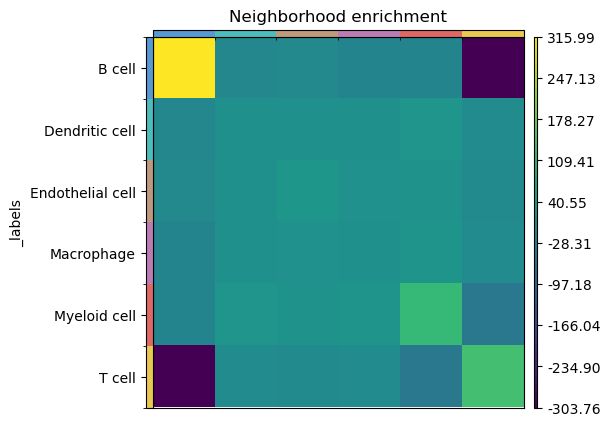

In [4]:
sq.gr.spatial_neighbors(adata, coord_type="generic", radius=140)
sq.gr.nhood_enrichment(adata, cluster_key="_labels")
sq.pl.nhood_enrichment(adata, cluster_key="_labels")

We see that in this sample, B cells frequently cluster together, while B and T cells have a negative enrichment score, meaning that the two do not mix very often.

## Downstream Analysis in R using spatstat

R has a great analysis ecosystem for spatial data, hence it can be desirable to continue analysis with packages such as `spatstat`. Below we show how you can export your data in an R-friendly format and perform some basic analysis using the `spatstat package`.

In [29]:
# getting the spatial information and cell types from the spatialproteomics object
df = ds.pp.get_layer_as_df()[["centroid-0", "centroid-1", "_labels"]]
# renaming the columns for better compatibility with R
df.columns = ["centroid.0", "centroid.1", "labels"]
df.head()

,centroid.0,centroid.1,labels
1,356.750973,1499.941634,Myeloid cell
2,363.116071,1421.816964,B cell
3,366.865169,1390.752809,T cell
4,370.197531,1518.111111,T cell
5,367.032051,1597.435897,T cell


At this point, it is most sensible to store the data frame to disk using `df.to_csv('your_path.csv')`, and reading it in with R. For demonstration purposes, we run R directly in this notebook.

In [30]:
%%R
# installing the spatstat package
install.packages("spatstat", quiet = TRUE)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [31]:
# send the python df to R, so that we can use it directly
%R -i df

Let's have a look at how B cells are spatially distributed in this sample. We can do this by using Ripley's K function. We compute what this function would like like if our cells were randomly distributed, and then compute what it actually looks like. Subsequently, we can compare the two curves. Interpretation is simple: if our observed curve is above the theoretical one, there is clustering in the sample.

number of data points exceeds 3000 - computing border correction estimate only
In addition: Warning message:
1 point was rejected as lying outside the specified window 


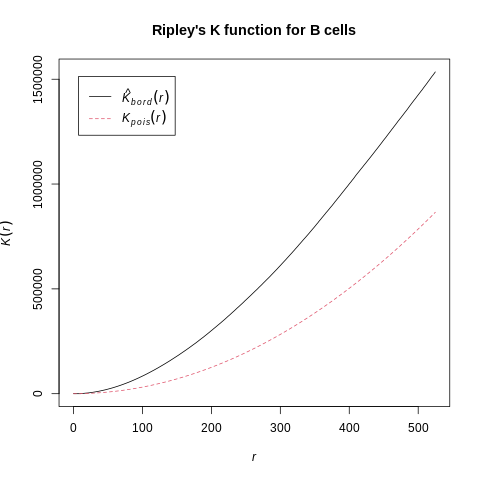

In [51]:
%%R
library(spatstat.geom)
library(spatstat.explore)

# convex hull around centroids
cvxhull <- convexhull.xy(cbind(df$centroid.1, y=df$centroid.0))

# subset to B cells
df_subset <- df[df[["labels"]] == "B cell", ]
# point pattern of B cell centroids inside hull
P <- ppp(df_subset$centroid.1, df_subset$centroid.0, poly = cvxhull$bdry[[1]])

# Ripley's K only
K <- Kest(P)

# plotting the result
plot(K, main = "Ripley's K function for B cells")

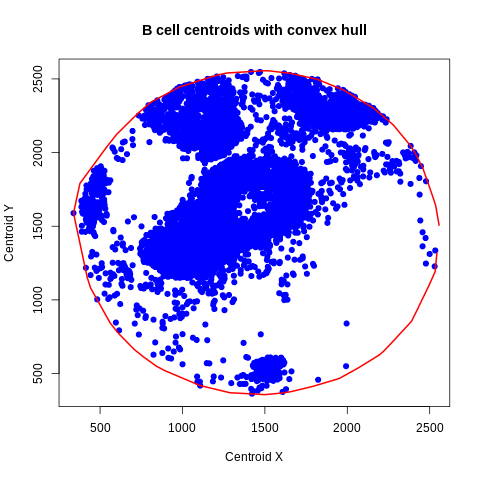

In [53]:
%%R
# quick visualization of the B cells and the convex hull
plot(
  df_subset$centroid.1, df_subset$centroid.0,
  xlab = "Centroid X",
  ylab = "Centroid Y",
  main = "B cell centroids with convex hull",
  pch = 19, col = "blue"
)
lines(cvxhull$bdry[[1]], col = "red", lwd = 2)